# Caption Generator

# Importing the required libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings
import numpy as np
import pandas as pd
from collections import Counter
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

python 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
keras version 2.2.4
tensorflow version 1.13.1


# Configuring the GPU memory for training purposes

In [2]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

def set_seed (sd=144):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    seed(sd)
    rn.seed(sd)
    set_random_seed(sd)

# Importing the Image dataset and its respective corpus

In [3]:
dir_Flickr_jpg = "D:/Study/Dataset/Flickr8k_Dataset/Flicker8k_Dataset/"
dir_Flickr_text = "D:/Study/Dataset/Flickr8k_text/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg files in Flicker8k: {}".format(len(jpgs)))

The number of jpg files in Flicker8k: 8091


In [4]:
#Finding the captions for each image
file = open(dir_Flickr_text, 'r', encoding='utf8')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt, columns = ["filename", "index", "caption"])

uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])

The number of unique file names : 8092
The distribution of the number of captions for each image:
                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


# Plotting few images and their captions from the dataset

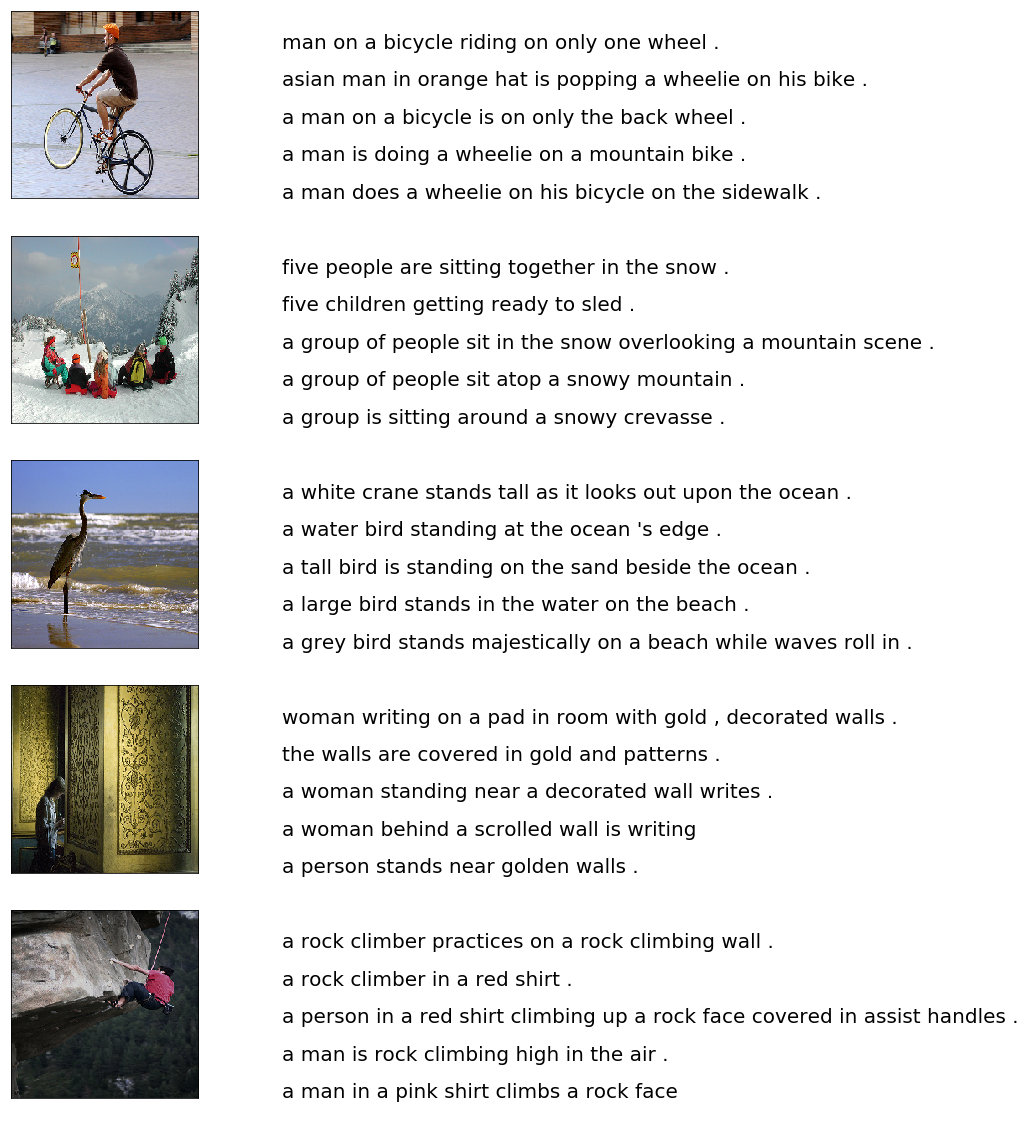

In [5]:
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image

npic = 5
npix = 224
target_size = (npix, npix, 3)

count = 1
fig = plt.figure(figsize = (10, 20))
for jpgfnm in uni_filenames[-5:]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]== jpgfnm].values)
    image_load = load_img(filename, target_size = target_size)
    
    ax = fig.add_subplot(npic, 2, count, xticks = [], yticks = [])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize = 20)
    count += 1
plt.show()

# Cleaning captions for further analysis

In [6]:
# Defining a function to calculate the top 3 words in all the captions available for the images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word": list(ct.keys()), "count": list(ct.values())})
    dfword = dfword.sort_values("count", ascending = False)
    dfword = dfword.reset_index()[["word", "count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975


# Cleaning the captions for further processing

In [7]:
import string
text_original = "I ate 1000 apples and a banana. I have python v3.7.1. It's 2:30 pm. Could you buy me iphone7?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('', '', string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)

print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text, printTF = False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("   {:10} : {:}".format(word, isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1, printTF = True)
print(text_no_numeric)

I ate 1000 apples and a banana. I have python v3.7.1. It's 2:30 pm. Could you buy me iphone7?

Remove punctuations..
I ate 1000 apples and a banana I have python v371 Its 230 pm Could you buy me iphone7

Remove a single character word..
 ate 1000 apples and banana have python v371 Its 230 pm Could you buy me iphone7

Remove words with numeric values..
   ate        : True
   1000       : False
   apples     : True
   and        : True
   banana     : True
   have       : True
   python     : True
   v371       : False
   Its        : True
   230        : False
   pm         : True
   Could      : True
   you        : True
   buy        : True
   me         : True
   iphone7    : False
 ate apples and banana have python Its pm Could you buy me


In [8]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

# Plotting the top 50 words that appear in the cleaned dataset

Vocabulary Size: 8763


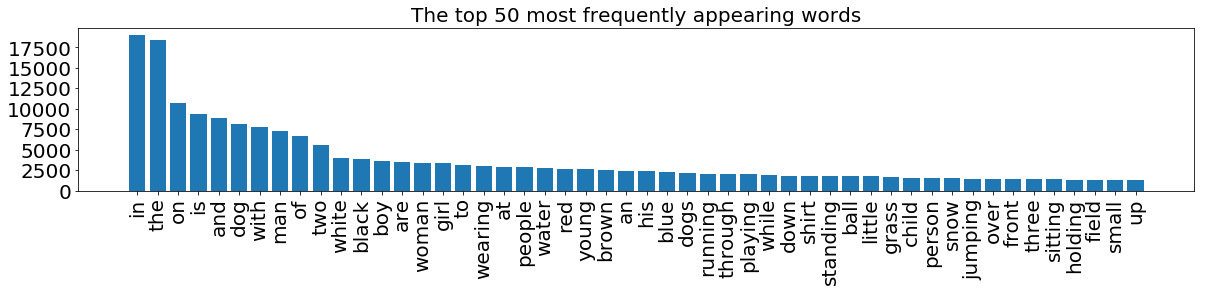

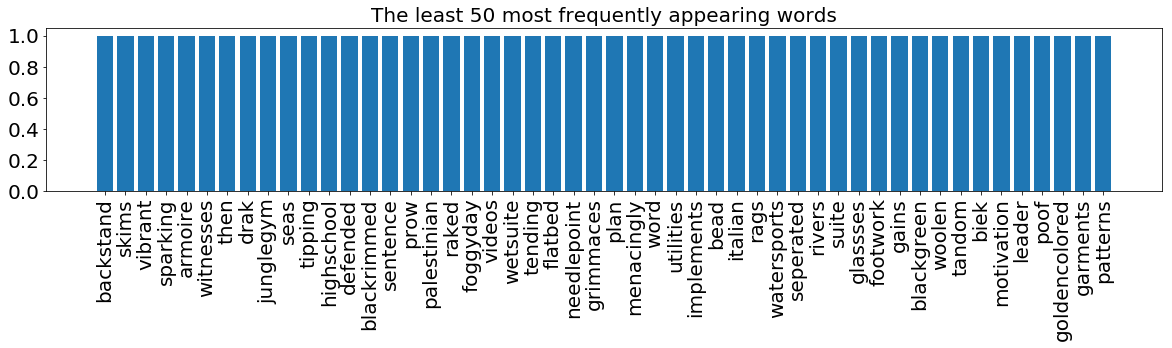

In [9]:
topn = 50

def plthist(dfsub, title = "The top 50 most frequently appearing words"):
    plt.figure(figsize = (20, 3))
    plt.bar(dfsub.index, dfsub["count"])
    plt.yticks(fontsize = 20)
    plt.xticks(dfsub.index, dfsub["word"], rotation = 90, fontsize = 20)
    plt.title(title, fontsize = 20)
    plt.show()
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn, :],
       title = "The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:, :],
       title = "The least 50 most frequently appearing words")

# Adding start and end sequence tokens for each captions

In [10]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq' + txt + 'endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [11]:
df_txt0[:5]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden buildingendseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into ...


# Loading VGG16 model and weights to extract features from the images

In [12]:
from keras.applications import VGG16

modelvgg = VGG16(include_top=True,weights=None)
## load the locally saved weights 
modelvgg.load_weights("D:/Study/Dataset/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

# Deleting the last layer of the model

In [13]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
modelvgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Feature Extraction

In [14]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

# Plotting similar images from the dataset

In [15]:
from sklearn.decomposition import PCA

encoder = np.array(list(images.values()))
pca = PCA(n_components=2)
y_pca = pca.fit_transform(encoder)

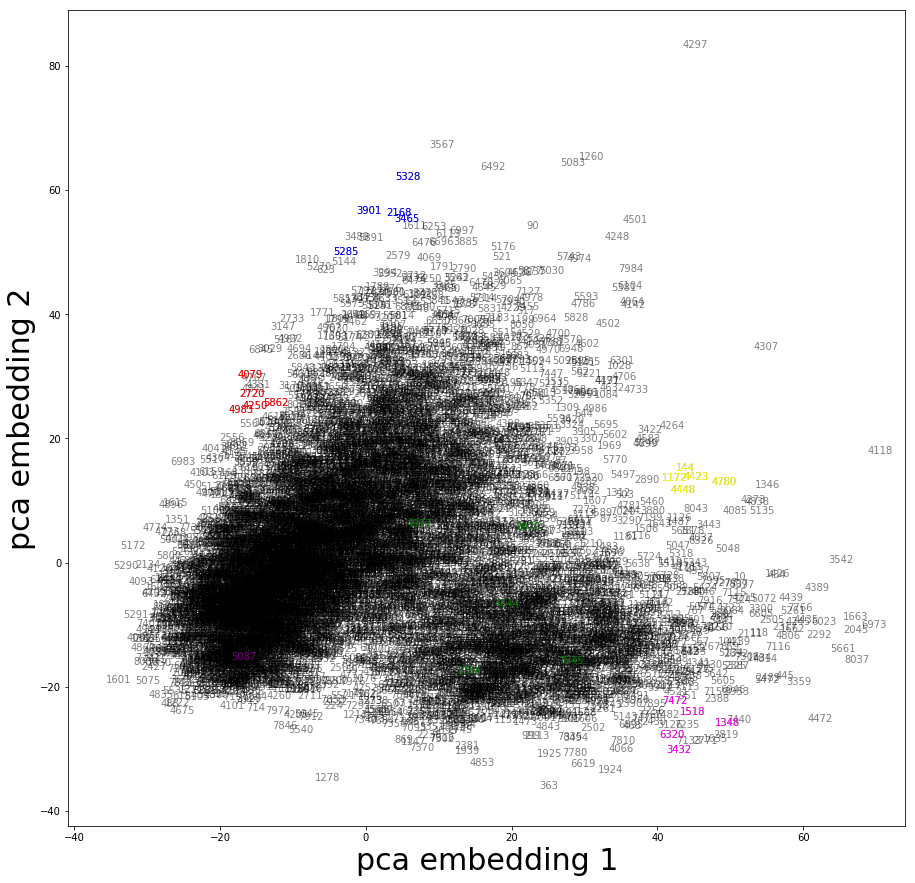

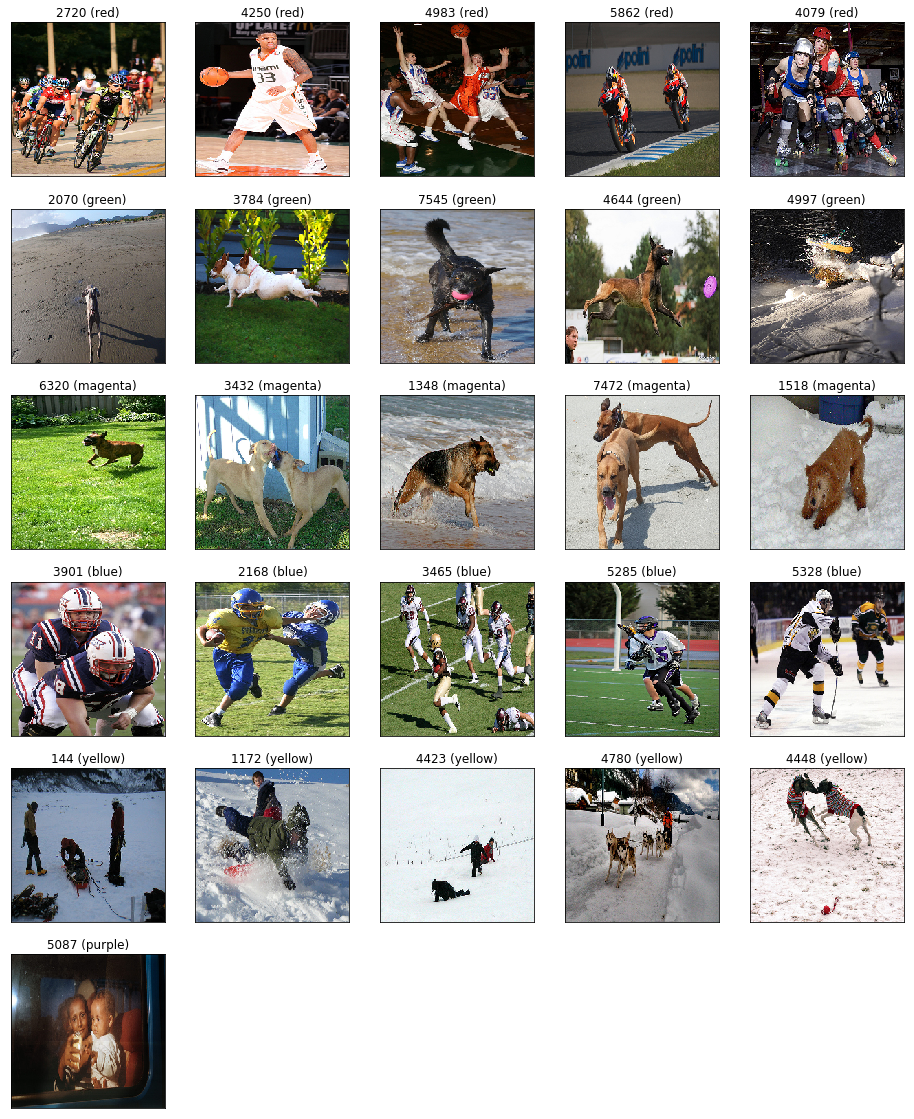

In [16]:
picked_pic = OrderedDict()
picked_pic["red"]     = [2720,4250,4983,5862,4079]
picked_pic["green"]   = [2070,3784,7545,4644, 4997]
picked_pic["magenta"] = [6320,3432,1348,7472, 1518]
picked_pic["blue"]    = [3901,2168,3465,5285,5328]
picked_pic["yellow"]  = [144,1172,4423,4780,4448]
picked_pic["purple"]  = [5087]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_pca[:,0],y_pca[:,1],c="white")

for irow in range(y_pca.shape[0]):
    ax.annotate(irow,y_pca[irow,:],color="black",alpha=0.5)
for color, irows in picked_pic.items():
    for irow in irows:
        ax.annotate(irow,y_pca[irow,:],color=color)
ax.set_xlabel("pca embedding 1",fontsize=30)
ax.set_ylabel("pca embedding 2",fontsize=30)
plt.show()

fig = plt.figure(figsize=(16,20))
count = 1
for color, irows in picked_pic.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
    
        ax = fig.add_subplot(len(picked_pic),5,count,
                         xticks=[],yticks=[])
        count += 1
        plt.imshow(image)
        plt.title("{} ({})".format(ivec,color))
plt.show()

# Merging the images and the captions for training

In [17]:
dimages, keepindex = [], []
# Creating a dataframe where only first caption is taken for processing
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(images)

In [18]:
df_txt0[:5]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up se...
5,1001773457_577c3a7d70.jpg,0,startseq black dog and spotted dog are fightin...
10,1002674143_1b742ab4b8.jpg,0,startseq little girl covered in paint sits in ...
15,1003163366_44323f5815.jpg,0,startseq man lays on bench while his dog sits ...
20,1007129816_e794419615.jpg,0,startseq man in an orange hat starring at some...


# Tokenizing the captions for further processing

In [19]:
# As the model cannot take texts as an input, they need to be converted into vectors
from keras.preprocessing.text import Tokenizer
nb_words = 8000
tokenizer = Tokenizer(nb_words = nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 5517
[[1, 35, 2, 62, 139, 6, 127, 51, 508, 8, 724, 2, 22, 2766, 1595], [1, 11, 7, 4, 792, 7, 16, 1349], [1, 43, 14, 152, 2, 628, 89, 2, 38, 8, 595, 1596, 10, 60, 249, 2, 1992], [1, 9, 629, 5, 213, 24, 21, 7, 89, 45, 131], [1, 9, 2, 22, 73, 100, 1350, 18, 672]]
